# Analysis of noisy DEJMPS

In [1]:
import numpy as np
import math
import importlib as imp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn

import main_1GnB as main

Erasure: same J, different p-->(1-alpha)p  =>  scale a,b,c,d by (1-alpha)

Depol.: different J-->J + beta(beta-2) * (J-0.25), same p => modify a,b, keep c,d

$$ a_\mathrm{depol} = (1+\beta(\beta-2))a - \frac{\beta(\beta-2)}{4}c$$
$$ b_\mathrm{depol} = (1+\beta(\beta-2))b - \frac{\beta(\beta-2)}{4}d$$

---
---
## Output fidelity and success probability

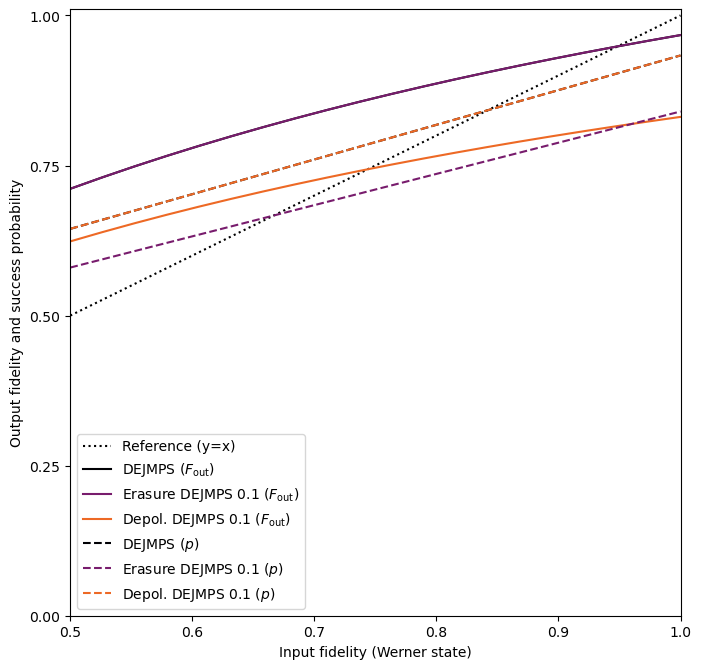

In [2]:
imp.reload(main)

prob_failure = 0.1
policy_names = ['DEJMPS', 'Erasure DEJMPS '+str(prob_failure), 'Depol. DEJMPS '+str(prob_failure)]

F_new = 0.9
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])
num_new_links = 5

main.policies_plot(policy_names, rho_new, num_new_links)

---
---
## Buffering performance

In [3]:
imp.reload(main)
main.AFplot_noisyDEJMPS_interactive()

interactive(children=(IntSlider(value=5, description='n', layout=Layout(width='60%'), max=15, min=1), FloatSli…

TODO: test with deterministic purification and artificial J with depolarising noise